In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import truvari
import joblib
import glob
import os
from IPython.display import display, Markdown

SZBINTY = pd.CategoricalDtype(truvari.SZBINS[1:], ordered=True)
ref_order = ["hg19", "grch38", "chm13", "pr1"]
sb.set()

In [2]:
metadata = pd.read_csv("../metadata/sample_metadata.txt", sep="\t")
metadata = metadata.set_index("Individual")

In [3]:
data = joblib.load("../stats/indiv_stats.jl")
#weird_sample = data["sample"] == "NA18939"
#data = data[~weird_sample & ~(data["merge"].str.startswith("removed"))]
redund_samples = ["HG00733", "NA12878", "NA24385"]
data = data[~(data["merge"].str.startswith("removed"))]
data = data[~((data["sample"].isin(redund_samples)) & (data["project"] == "eichler"))]

In [4]:
def plot_sv_counts(m_data):
    """
    Creates a view of the data by reference/sample/project and by svtype with the counts
    Creates a plot, also
    Returns the data view overall and the dataview by svtype
    """
    view = []
    view_bytype = []
    for idx, subdat in m_data.groupby(["reference", "sample", "project"]):
        view.append([idx[0], idx[1], metadata.loc[idx[1]]["Superpopulation code"], len(subdat)])
        subdat["count"] = 1
        tygrp = subdat.groupby(["svtype"]).sum()["count"]
        view_bytype.append([idx[0], idx[1], metadata.loc[idx[1]]["Superpopulation code"], "DEL", tygrp.loc["DEL"]])
        view_bytype.append([idx[0], idx[1], metadata.loc[idx[1]]["Superpopulation code"], "INS", tygrp.loc["INS"]])

    view = pd.DataFrame(view, columns=["reference", "sample", "Superpopulation", "svcount"])
    view_bytype = pd.DataFrame(view_bytype, columns=["reference", "sample", "Superpopulation", "svtype", "svcount"])
    p = sb.catplot(data=view, x="reference", y="svcount", hue="Superpopulation", order=ref_order)
    p.set(title="SV Counts per-sample by reference", xlabel="Reference", ylabel="Count")
    plt.show()
    p = sb.catplot(data=view_bytype, x="svtype", y="svcount", hue="Superpopulation", col="reference", col_order=ref_order)
    #p.set(title="SV Counts per-sample by reference/SVTYPE", xlabel="Reference", ylabel="Count")
    p.fig.subplots_adjust(top=0.9) 
    hide = p.fig.suptitle('SV Counts per-sample by reference/SVTYPE')
    plt.show()
    
    with pd.option_context('display.float_format', '{:,.0f}'.format):
        display(view.groupby(["reference"]).describe())
    
    with pd.option_context('display.float_format', '{:,.0f}'.format):
        display(view_bytype.groupby(["reference", "svtype"]).describe())

    return view, view_bytype
    
def plot_svsize_counts(m_data):
    """
    Creates a view of the data by reference/sample/project and by sizebin with the counts
    Creates a plot, also
    Returns the data view overall and the dataview by svtype
    """
    view = []
    view_bytype = []
    for idx, subdat in m_data.groupby(["reference", "sample", "project"]):
        for size, subdat2 in subdat.groupby("szbin"):
            view.append([idx[0], idx[1], metadata.loc[idx[1]]["Superpopulation code"], size, len(subdat2)])
        for idx2, subdat2 in subdat.groupby(["svtype", "szbin"]):
            svtype, szbin = idx2        
            view_bytype.append([idx[0], idx[1], metadata.loc[idx[1]]["Superpopulation code"], svtype, szbin, len(subdat2)])

    view = pd.DataFrame(view, columns=["reference", "sample", "Superpopulation", "szbin", "svcount"])
    view_bytype = pd.DataFrame(view_bytype, columns=["reference", "sample", "Superpopulation", "svtype", "szbin", "svcount"])
    p = sb.barplot(data=view, x="szbin", y="svcount", order=truvari.SZBINS[1:], hue="reference", hue_order=ref_order)
    p.set(title=f"SV count by SV size")
    plt.xticks(rotation=45, ha="right")
    plt.show()
    p = sb.catplot(data=view_bytype, kind="bar", x="szbin", y="svcount", col="reference", hue="svtype", col_order=ref_order)
    [plt.setp(ax.get_xticklabels(), rotation=45, ha="right") for ax in p.axes.flat]
    p.fig.subplots_adjust(top=0.9) 
    hide = p.fig.suptitle('SV count by SV size/type per-reference')
    plt.show()
    view["szbin"] = view["szbin"].astype(SZBINTY)
    view_bytype["szbin"] = view_bytype["szbin"].astype(SZBINTY)
    
    with pd.option_context('display.float_format', '{:,.0f}'.format):
        display(view.groupby(["reference", "szbin"]).describe())
        display(view_bytype.groupby(["reference", "svtype", "szbin"]).describe())

    return view, view_bytype

def plot_hethom_stats(m_data):
    """
    Creates a view of the data by reference/sample/project and summarizes the GT counts and ratios
    Creates a plot, also
    Return the data view
    """
    view = []
    for idx, subdat in m_data.groupby(["reference", "sample", "project"]):
        subdat["count"] = 1
        gtgrp = subdat.groupby(["GT"]).sum()["count"]    
        view.append([idx[0], idx[1], metadata.loc[idx[1]]["Superpopulation code"], "TOT", gtgrp.loc["HET"], gtgrp.loc["HOM"]])
        for idx2, subdat2 in subdat.groupby(["svtype"]):
            if idx2 not in ["DEL", "INS"]: continue
            gtgrp = subdat2.groupby(["GT"]).sum()["count"]   
            view.append([idx[0], idx[1], metadata.loc[idx[1]]["Superpopulation code"], idx2, gtgrp.loc["HET"], gtgrp.loc["HOM"]])
    view = pd.DataFrame(view, columns=["reference", "sample", "Superpopulation", "svtype", "HET", "HOM"])
    view["Ratio"] = view["HET"] / view["HOM"]

    p = sb.catplot(data=view[view["svtype"] == "TOT"], x="reference", y="Ratio", hue="Superpopulation", order=ref_order)
    p.set(title="Het/Hom ratio per-sample by reference", xlabel="Reference", ylabel="Het/Hom Ratio")
    plt.show()
    
    with pd.option_context('display.float_format', '{:.2f}'.format):
        display(view.groupby(["reference", "svtype"])["Ratio"].describe())
    return view

First, let's look at just the generic "strict" strategy's numbers

# Strict Merging - Per-Sample Stats

## SVCounts per-sample

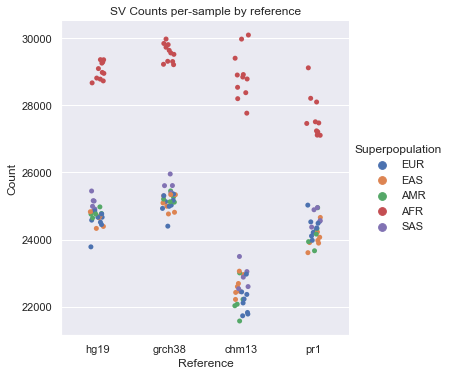

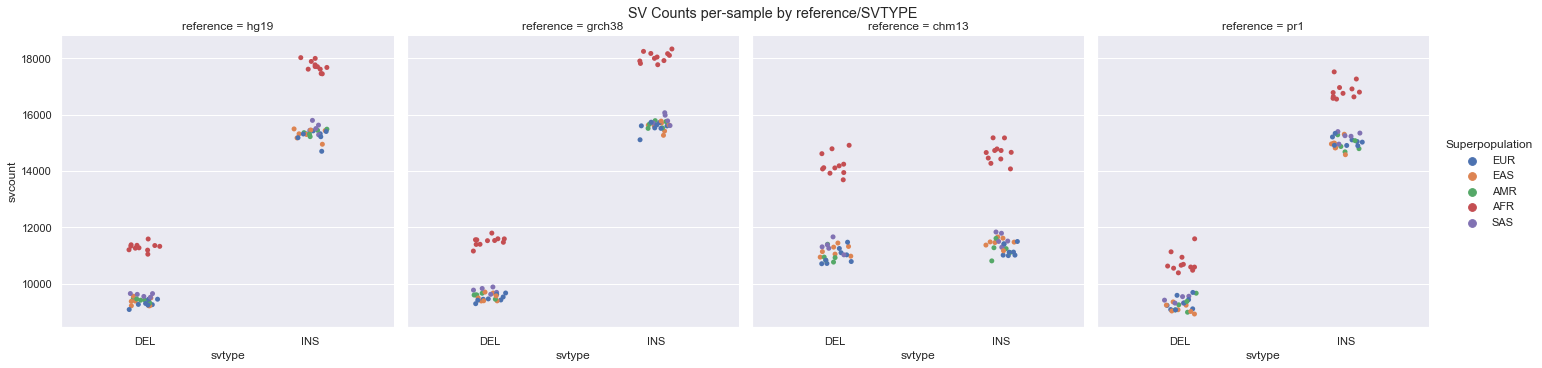

svcount                                                
            count   mean   std    min    25%    50%    75%    max
reference                                                        
chm13          36 24,423 3,054 21,581 22,231 22,792 28,240 30,090
grch38         36 26,534 2,052 24,403 25,126 25,350 29,240 29,971
hg19           36 26,048 2,023 23,787 24,669 24,856 28,738 29,357
pr1            36 25,318 1,609 23,614 24,153 24,539 27,120 29,114

svcount                                                
                   count   mean   std    min    25%    50%    75%    max
reference svtype                                                        
chm13     DEL         36 12,062 1,494 10,711 10,971 11,305 13,929 14,914
          INS         36 12,361 1,566 10,812 11,270 11,501 14,312 15,179
grch38    DEL         36 10,162   919  9,293  9,489  9,668 11,397 11,798
          INS         36 16,371 1,141 15,110 15,607 15,728 17,840 18,332
hg19      DEL         36  9,981   901  9,086  9,343  9,494 11,197 11,589
          INS         36 16,067 1,129 14,701 15,313 15,444 17,499 18,024
pr1       DEL         36  9,727   736  8,927  9,202  9,396 10,498 11,595
          INS         36 15,590   886 14,580 14,945 15,222 16,594 17,519

## SVCounts by SZBIN per-sample

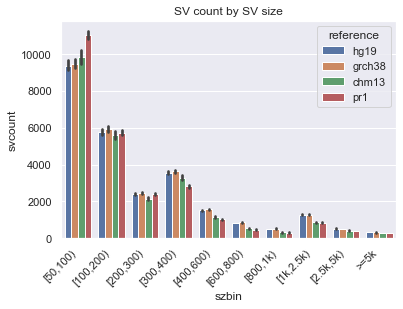

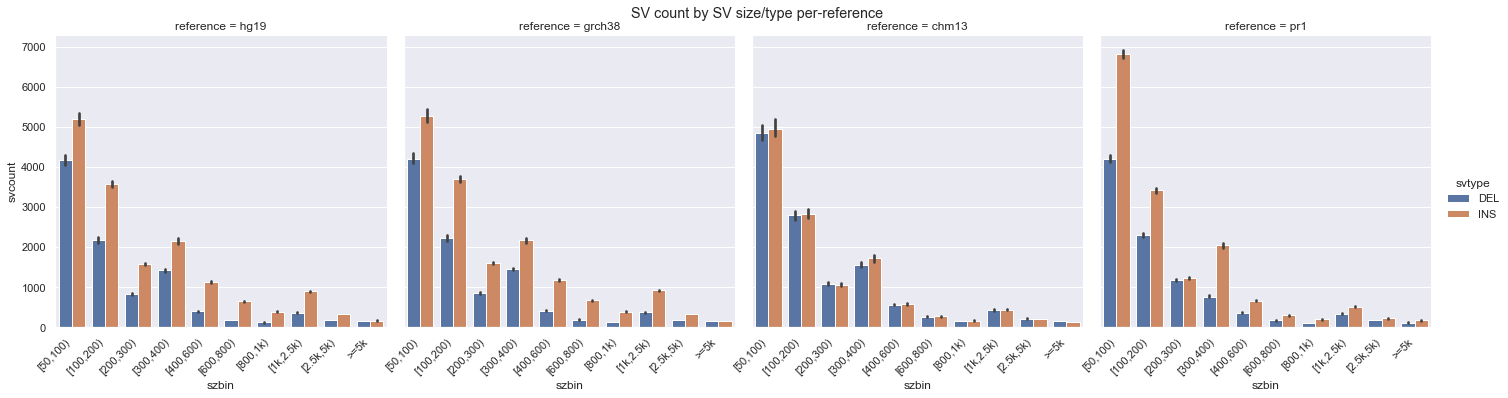

svcount                                                
                      count   mean   std    min    25%    50%    75%    max
reference szbin                                                            
chm13     [50,100)       36  9,816 1,214  8,710  8,977  9,141 11,352 11,943
          [100,200)      36  5,622   711  4,949  5,116  5,254  6,477  6,956
          [200,300)      36  2,151   261  1,858  1,968  2,020  2,455  2,721
          [300,400)      36  3,273   458  2,849  2,928  3,032  3,810  4,255
          [400,600)      36  1,143   127    943  1,054  1,091  1,306  1,375
          [600,800)      36    535    75    448    479    508    609    721
          [800,1k)       36    319    39    260    291    306    354    408
          [1k,2.5k)      36    869   111    750    787    822    993  1,057
          [2.5k,5k)      36    412    54    345    372    395    468    521
          >=5k           36    283    36    226    256    272    318    346
grch38    [50,100)       36  9,482   831  8,711  8,911  9,016 10,594 10,892
          [100,200)      36  5,923   464  5,417  5,604  5,684  6,549  6,707
          [200,300)      36  2,445   169  2,230  2,332  2,375  2,620  2,754
          [300,400)      36  3,626   312  3,339  3,402  3,444  4,042  4,229
          [400,600)      36  1,579    87  1,465  1,508  1,558  1,656  1,757
          [600,800)      36    859    54    789    816    844    913    964
          [800,1k)       36    514    36    464    488    508    528    590
          [1k,2.5k)      36  1,285    79  1,176  1,226  1,258  1,383  1,422
          [2.5k,5k)      36    506    41    439    476    496    530    605
          >=5k           36    315    26    264    299    308    328    365
hg19      [50,100)       36  9,368   819  8,567  8,798  8,934 10,509 10,748
          [100,200)      36  5,760   455  5,209  5,453  5,520  6,377  6,541
          [200,300)      36  2,405   167  2,176  2,291  2,332  2,581  2,703
          [300,400)      36  3,565   307  3,299  3,349  3,390  3,964  4,148
          [400,600)      36  1,522    84  1,385  1,462  1,503  1,600  1,700
          [600,800)      36    827    55    754    789    805    884    941
          [800,1k)       36    504    34    457    480    497    530    582
          [1k,2.5k)      36  1,265    81  1,150  1,198  1,241  1,352  1,411
          [2.5k,5k)      36    515    39    451    488    511    536    613
          >=5k           36    316    25    269    301    311    331    363
pr1       [50,100)       36 11,037   641 10,384 10,593 10,700 11,780 12,424
          [100,200)      36  5,725   361  5,258  5,472  5,587  6,080  6,559
          [200,300)      36  2,418   156  2,221  2,297  2,356  2,588  2,803
          [300,400)      36  2,812   260  2,549  2,626  2,656  3,031  3,524
          [400,600)      36  1,024    69    926    973    998  1,093  1,176
          [600,800)      36    468    49    394    439    454    485    602
          [800,1k)       36    305    26    261    284    298    329    360
          [1k,2.5k)      36    850    58    768    813    828    899    968
          [2.5k,5k)      36    395    28    356    376    388    410    468
          >=5k           36    285    17    259    271    282    298    316

svcount                                        
                             count  mean std   min   25%   50%   75%   max
reference svtype szbin                                                    
chm13     DEL    [50,100)       36 4,853 599 4,295 4,446 4,545 5,589 5,959
                 [100,200)      36 2,792 357 2,386 2,534 2,614 3,230 3,429
                 [200,300)      36 1,087 130   939   996 1,032 1,236 1,344
                 [300,400)      36 1,553 184 1,373 1,426 1,462 1,748 1,964
                 [400,600)      36   564  68   485   510   538   630   708
...                            ...   ...  ..   ...   ...   ...   ...   ...
pr1       INS    [600,800)      36   296  29   241   280   290   308   369
                 [800,1k)       36   192  19   161   179   188   205   253
                 [1k,2.5k)      36   514  31   462   490   510   536   580
                 [2.5k,5k)      36   217  15   194   204   217   224   255
                 >=5k           36   169  12   143   160   168   179   188

[80 rows x 8 columns]

## SV HET/HOM Ratios

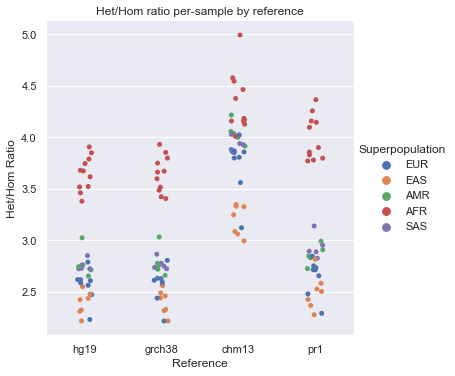

count  mean  std  min  25%  50%  75%  max
reference svtype                                           
chm13     DEL     36.00  3.54 0.42 2.68 3.42 3.58 3.78 4.53
          INS     36.00  4.28 0.52 3.26 4.08 4.28 4.58 5.52
          TOT     36.00  3.89 0.46 2.99 3.74 3.93 4.16 4.99
grch38    DEL     36.00  2.79 0.49 2.04 2.45 2.65 3.28 3.66
          INS     36.00  3.01 0.55 2.22 2.62 2.79 3.54 4.11
          TOT     36.00  2.92 0.52 2.21 2.56 2.74 3.44 3.93
hg19      DEL     36.00  2.80 0.49 2.06 2.47 2.65 3.31 3.67
          INS     36.00  3.00 0.56 2.24 2.61 2.77 3.56 4.06
          TOT     36.00  2.92 0.53 2.22 2.56 2.72 3.47 3.91
pr1       DEL     36.00  2.86 0.60 2.03 2.48 2.64 3.46 4.09
          INS     36.00  3.26 0.68 2.34 2.82 3.00 3.98 4.55
          TOT     36.00  3.10 0.64 2.28 2.70 2.85 3.78 4.36

In [5]:
strict_data = data[(data["merge"] == "strict")]
display(Markdown("# Strict Merging - Per-Sample Stats"))
display(Markdown("## SVCounts per-sample"))
strict_sv_counts = plot_sv_counts(strict_data)
display(Markdown("## SVCounts by SZBIN per-sample"))
strict_sz_counts = plot_svsize_counts(strict_data)
display(Markdown("## SV HET/HOM Ratios"))
strict_gt_counts = plot_hethom_stats(strict_data)

Then, we'll look at a comparison of the strategies and what it means for the truth set SV counts by comparing with 'exact' and 'loose' merges

# Exact Merging - Per-Sample Stats

## SVCounts per-sample

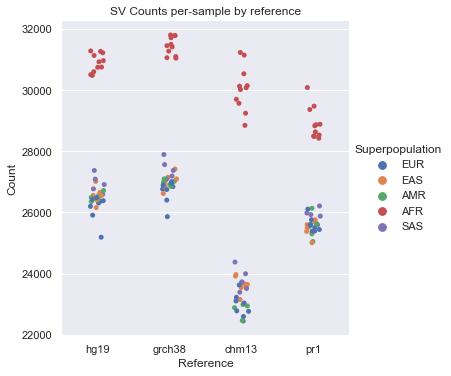

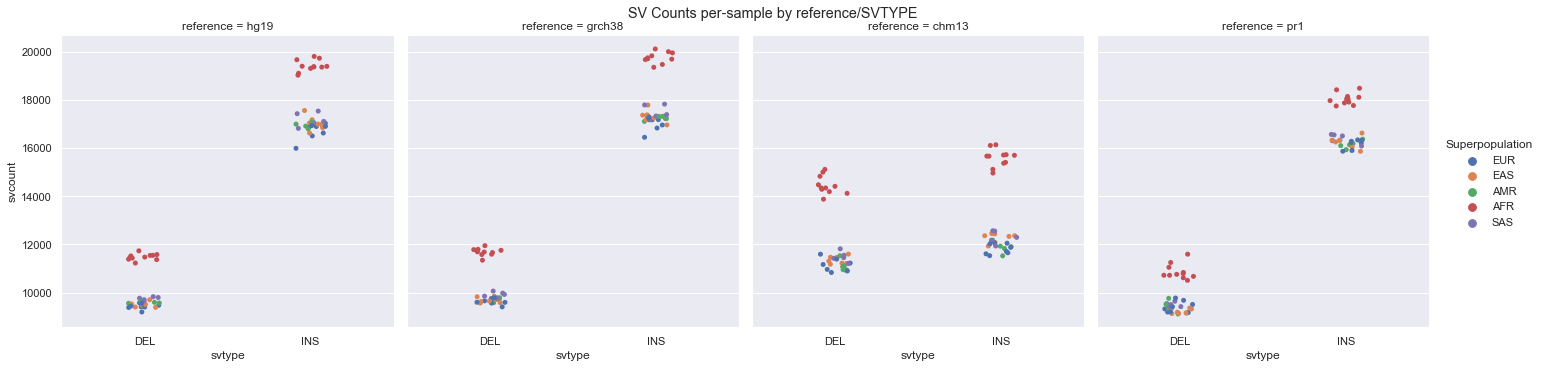

svcount                                                
            count   mean   std    min    25%    50%    75%    max
reference                                                        
chm13          36 25,377 3,201 22,446 23,084 23,653 29,325 31,230
grch38         36 28,346 2,117 25,860 26,907 27,096 31,068 31,802
hg19           36 27,841 2,091 25,188 26,414 26,624 30,530 31,281
pr1            36 26,620 1,590 25,008 25,498 25,758 28,486 30,084

svcount                                                
                   count   mean   std    min    25%    50%    75%    max
reference svtype                                                        
chm13     DEL         36 12,238 1,523 10,835 11,176 11,457 14,142 15,119
          INS         36 13,139 1,687 11,526 11,933 12,314 15,183 16,139
grch38    DEL         36 10,324   932  9,408  9,647  9,788 11,586 11,950
          INS         36 18,022 1,196 16,452 17,217 17,344 19,527 20,119
hg19      DEL         36 10,137   915  9,195  9,468  9,645 11,375 11,736
          INS         36 17,703 1,190 15,993 16,905 17,054 19,160 19,810
pr1       DEL         36  9,830   737  9,112  9,291  9,506 10,630 11,596
          INS         36 16,790   874 15,868 16,190 16,332 17,798 18,488

## SVCounts by SZBIN per-sample

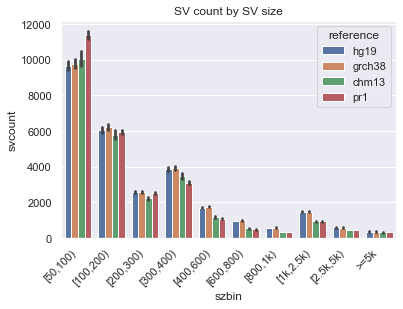

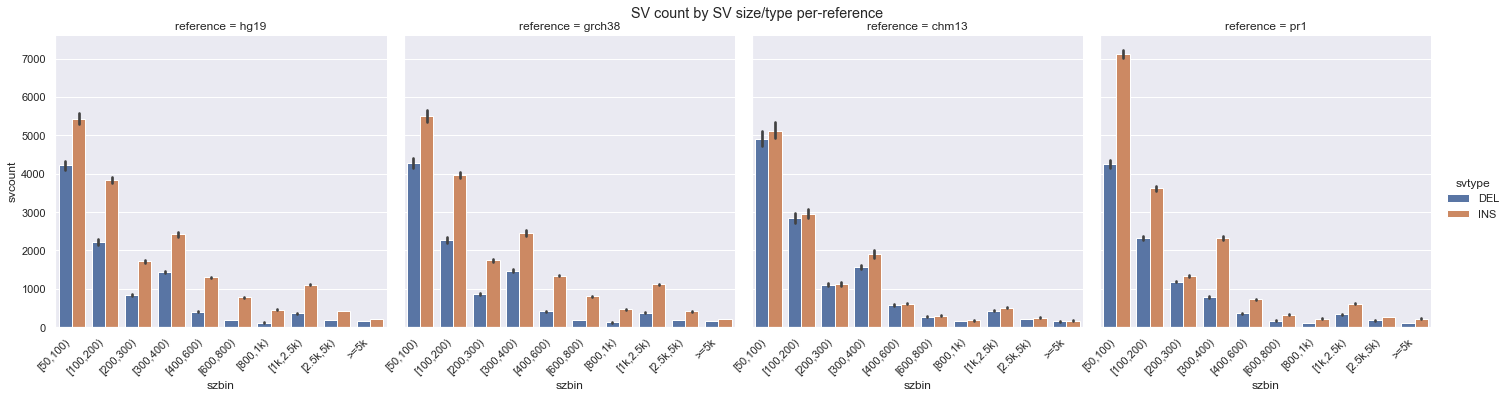

svcount                                                
                      count   mean   std    min    25%    50%    75%    max
reference szbin                                                            
chm13     [50,100)       36 10,050 1,249  8,937  9,201  9,380 11,618 12,217
          [100,200)      36  5,802   741  5,124  5,298  5,430  6,686  7,175
          [200,300)      36  2,232   273  1,911  2,046  2,095  2,551  2,806
          [300,400)      36  3,484   482  3,058  3,138  3,226  4,046  4,504
          [400,600)      36  1,190   132    980  1,098  1,134  1,355  1,437
          [600,800)      36    560    79    479    500    529    642    748
          [800,1k)       36    337    43    274    307    320    377    437
          [1k,2.5k)      36    941   127    808    846    885  1,083  1,158
          [2.5k,5k)      36    462    62    378    415    439    530    578
          >=5k           36    318    44    245    286    305    361    396
grch38    [50,100)       36  9,784   848  8,943  9,184  9,300 10,925 11,181
          [100,200)      36  6,233   476  5,642  5,900  5,979  6,849  7,028
          [200,300)      36  2,602   174  2,372  2,490  2,530  2,788  2,904
          [300,400)      36  3,927   317  3,599  3,711  3,739  4,346  4,527
          [400,600)      36  1,759    93  1,598  1,702  1,735  1,832  1,951
          [600,800)      36  1,001    59    924    965    983  1,061  1,131
          [800,1k)       36    588    42    531    553    579    614    678
          [1k,2.5k)      36  1,489    87  1,361  1,428  1,454  1,577  1,646
          [2.5k,5k)      36    595    44    515    561    586    621    694
          >=5k           36    367    29    303    353    362    380    425
hg19      [50,100)       36  9,665   838  8,782  9,088  9,200 10,824 11,038
          [100,200)      36  6,060   466  5,422  5,745  5,816  6,668  6,853
          [200,300)      36  2,561   173  2,342  2,444  2,488  2,748  2,861
          [300,400)      36  3,864   313  3,516  3,650  3,684  4,260  4,443
          [400,600)      36  1,697    90  1,533  1,646  1,673  1,770  1,893
          [600,800)      36    965    60    877    925    946  1,028  1,101
          [800,1k)       36    578    40    515    547    569    610    658
          [1k,2.5k)      36  1,470    90  1,332  1,410  1,429  1,550  1,639
          [2.5k,5k)      36    610    43    528    578    606    634    709
          >=5k           36    371    29    310    357    365    386    421
pr1       [50,100)       36 11,387   631 10,776 10,923 11,088 12,163 12,599
          [100,200)      36  5,951   364  5,532  5,688  5,782  6,320  6,720
          [200,300)      36  2,519   156  2,335  2,406  2,442  2,694  2,868
          [300,400)      36  3,105   240  2,870  2,945  2,969  3,303  3,784
          [400,600)      36  1,089    70    987  1,036  1,062  1,164  1,228
          [600,800)      36    498    50    426    468    485    512    630
          [800,1k)       36    333    29    287    310    326    353    397
          [1k,2.5k)      36    951    63    855    908    930  1,006  1,078
          [2.5k,5k)      36    447    31    395    426    444    468    524
          >=5k           36    340    16    305    326    340    353    368

svcount                                        
                             count  mean std   min   25%   50%   75%   max
reference svtype szbin                                                    
chm13     DEL    [50,100)       36 4,920 608 4,346 4,514 4,604 5,660 6,048
                 [100,200)      36 2,841 367 2,423 2,568 2,659 3,298 3,490
                 [200,300)      36 1,106 135   948 1,010 1,046 1,260 1,364
                 [300,400)      36 1,575 187 1,392 1,448 1,482 1,777 1,986
                 [400,600)      36   573  69   496   520   546   640   716
...                            ...   ...  ..   ...   ...   ...   ...   ...
pr1       INS    [600,800)      36   325  30   269   307   319   334   396
                 [800,1k)       36   220  22   186   206   216   231   288
                 [1k,2.5k)      36   613  37   547   586   608   640   697
                 [2.5k,5k)      36   269  20   233   259   269   279   314
                 >=5k           36   224  12   196   219   223   233   243

[80 rows x 8 columns]

## SV HET/HOM Ratios

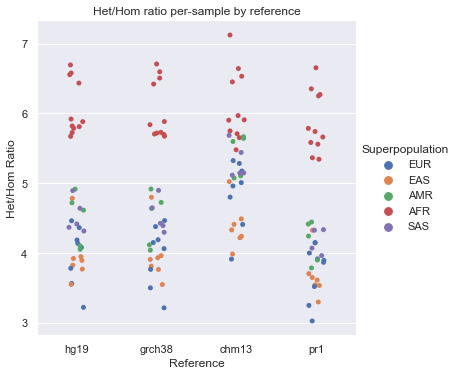

count  mean  std  min  25%  50%  75%   max
reference svtype                                            
chm13     DEL     36.00  3.93 0.49 2.94 3.72 3.95 4.22  5.08
          INS     36.00  7.48 1.38 4.89 6.61 7.30 8.15 10.79
          TOT     36.00  5.29 0.76 3.91 4.92 5.23 5.69  7.12
grch38    DEL     36.00  3.10 0.56 2.25 2.74 2.95 3.70  4.14
          INS     36.00  6.51 1.61 3.91 5.28 6.03 7.79  9.81
          TOT     36.00  4.75 0.97 3.22 4.02 4.45 5.70  6.71
hg19      DEL     36.00  3.10 0.57 2.26 2.73 2.94 3.74  4.14
          INS     36.00  6.54 1.64 3.92 5.33 6.02 7.89  9.87
          TOT     36.00  4.76 0.98 3.22 4.03 4.44 5.74  6.69
pr1       DEL     36.00  3.07 0.66 2.18 2.62 2.84 3.76  4.48
          INS     36.00  5.90 1.47 3.60 4.86 5.45 7.14  8.96
          TOT     36.00  4.49 1.01 3.03 3.77 4.15 5.41  6.65

In [6]:
exact_data = data[(data["merge"] == "exact")]

display(Markdown("# Exact Merging - Per-Sample Stats"))
display(Markdown("## SVCounts per-sample"))
exact_sv_counts = plot_sv_counts(exact_data)
display(Markdown("## SVCounts by SZBIN per-sample"))
exact_sz_counts = plot_svsize_counts(exact_data)
display(Markdown("## SV HET/HOM Ratios"))
exact_gt_counts = plot_hethom_stats(exact_data)

# Loose Merging - Per-Sample Stats

## SVCounts per-sample

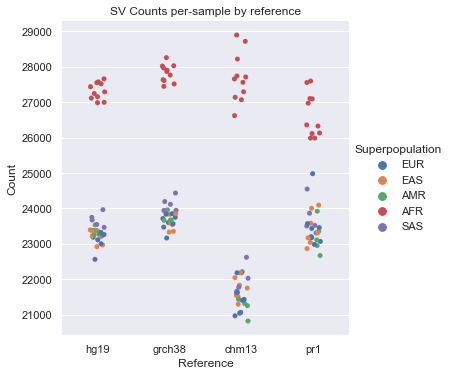

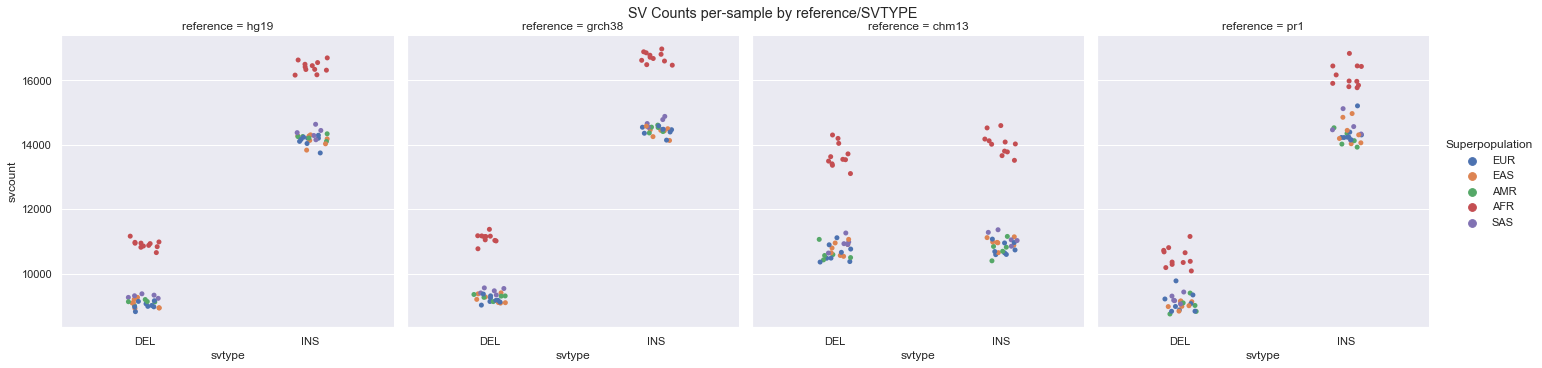

svcount                                                
            count   mean   std    min    25%    50%    75%    max
reference                                                        
chm13          36 23,484 2,879 20,823 21,434 21,931 27,084 28,894
grch38         36 24,993 1,919 23,165 23,665 23,852 27,538 28,256
hg19           36 24,533 1,893 22,564 23,253 23,387 27,025 27,657
pr1            36 24,442 1,588 22,671 23,197 23,578 26,018 27,595

svcount                                                
                   count   mean   std    min    25%    50%    75%    max
reference svtype                                                        
chm13     DEL         36 11,632 1,398 10,359 10,584 10,916 13,372 14,301
          INS         36 11,852 1,486 10,397 10,837 11,037 13,689 14,593
grch38    DEL         36  9,831   870  9,023  9,194  9,360 11,018 11,374
          INS         36 15,162 1,055 14,131 14,459 14,544 16,511 16,970
hg19      DEL         36  9,656   852  8,820  9,051  9,198 10,822 11,162
          INS         36 14,877 1,048 13,744 14,176 14,278 16,205 16,693
pr1       DEL         36  9,527   711  8,747  8,999  9,168 10,212 11,153
          INS         36 14,915   891 13,924 14,223 14,453 15,811 16,832

## SVCounts by SZBIN per-sample

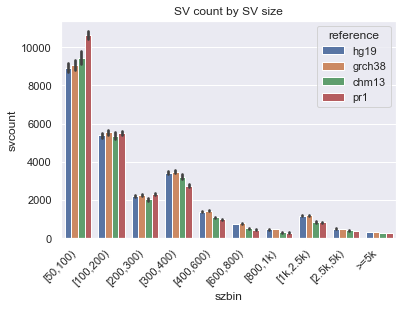

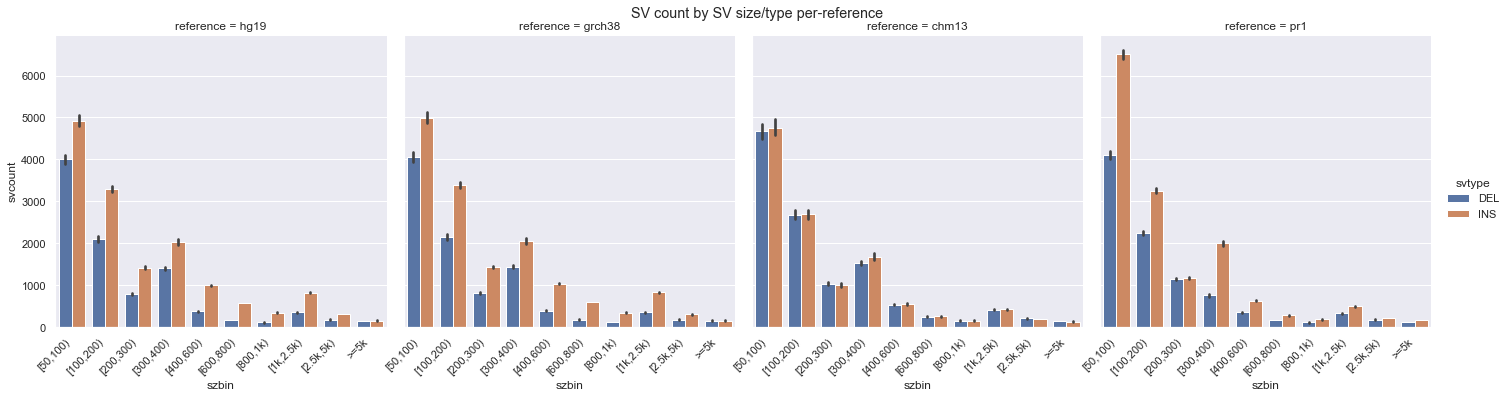

svcount                                               
                      count   mean   std   min    25%    50%    75%    max
reference szbin                                                           
chm13     [50,100)       36  9,431 1,137 8,390  8,655  8,788 10,882 11,428
          [100,200)      36  5,365   661 4,741  4,893  5,006  6,160  6,615
          [200,300)      36  2,042   242 1,771  1,870  1,922  2,313  2,573
          [300,400)      36  3,206   445 2,799  2,876  2,971  3,724  4,173
          [400,600)      36  1,086   118   906  1,010  1,044  1,227  1,303
          [600,800)      36    512    73   424    460    482    575    697
          [800,1k)       36    307    36   253    282    298    340    385
          [1k,2.5k)      36    846   108   731    765    800    968  1,033
          [2.5k,5k)      36    406    53   343    366    392    459    513
          >=5k           36    282    36   225    256    272    316    345
grch38    [50,100)       36  9,039   781 8,315  8,500  8,602 10,100 10,364
          [100,200)      36  5,545   426 5,109  5,239  5,332  6,124  6,261
          [200,300)      36  2,254   157 2,027  2,152  2,192  2,421  2,542
          [300,400)      36  3,488   304 3,210  3,272  3,310  3,894  4,064
          [400,600)      36  1,428    73 1,325  1,372  1,412  1,484  1,580
          [600,800)      36    780    49   719    739    769    823    879
          [800,1k)       36    468    33   431    443    456    487    544
          [1k,2.5k)      36  1,194    76 1,096  1,138  1,166  1,287  1,335
          [2.5k,5k)      36    487    40   424    460    476    510    584
          >=5k           36    310    25   261    294    304    323    359
hg19      [50,100)       36  8,929   772 8,227  8,390  8,510 10,015 10,235
          [100,200)      36  5,389   417 4,907  5,099  5,176  5,952  6,095
          [200,300)      36  2,216   156 1,997  2,108  2,152  2,380  2,494
          [300,400)      36  3,429   298 3,164  3,220  3,260  3,821  3,978
          [400,600)      36  1,378    71 1,264  1,330  1,362  1,430  1,530
          [600,800)      36    750    49   691    716    732    798    861
          [800,1k)       36    461    31   424    436    447    488    529
          [1k,2.5k)      36  1,174    78 1,068  1,116  1,150  1,256  1,322
          [2.5k,5k)      36    495    38   436    469    488    513    590
          >=5k           36    312    25   264    297    306    325    357
pr1       [50,100)       36 10,618   643 9,956 10,119 10,290 11,245 11,985
          [100,200)      36  5,502   356 5,045  5,236  5,350  5,819  6,225
          [200,300)      36  2,330   154 2,142  2,211  2,278  2,479  2,654
          [300,400)      36  2,753   256 2,505  2,564  2,609  2,964  3,416
          [400,600)      36    985    65   893    937    966  1,049  1,105
          [600,800)      36    452    48   386    418    442    472    583
          [800,1k)       36    297    25   258    277    293    314    353
          [1k,2.5k)      36    832    58   751    792    810    882    946
          [2.5k,5k)      36    390    29   349    370    384    406    472
          >=5k           36    284    17   258    270    282    297    316

svcount                                        
                             count  mean std   min   25%   50%   75%   max
reference svtype szbin                                                    
chm13     DEL    [50,100)       36 4,672 560 4,140 4,274 4,388 5,368 5,692
                 [100,200)      36 2,675 328 2,296 2,440 2,516 3,074 3,266
                 [200,300)      36 1,037 119   901   952   981 1,168 1,266
                 [300,400)      36 1,526 179 1,357 1,396 1,438 1,716 1,932
                 [400,600)      36   537  63   466   487   516   593   680
...                            ...   ...  ..   ...   ...   ...   ...   ...
pr1       INS    [600,800)      36   282  28   232   264   276   296   351
                 [800,1k)       36   185  19   159   172   180   194   246
                 [1k,2.5k)      36   498  32   447   474   494   518   560
                 [2.5k,5k)      36   213  16   187   201   212   221   257
                 >=5k           36   168  12   144   159   166   178   187

[80 rows x 8 columns]

## SV HET/HOM Ratios

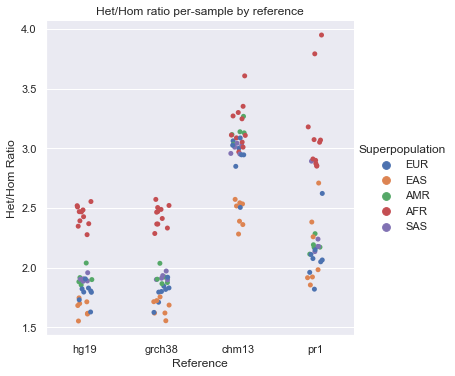

count  mean  std  min  25%  50%  75%  max
reference svtype                                           
chm13     DEL     36.00  2.77 0.28 2.12 2.74 2.83 2.93 3.28
          INS     36.00  3.16 0.34 2.43 3.09 3.21 3.33 3.97
          TOT     36.00  2.95 0.30 2.28 2.92 3.02 3.11 3.61
grch38    DEL     36.00  2.26 0.35 1.69 2.03 2.18 2.60 2.87
          INS     36.00  1.85 0.30 1.47 1.65 1.74 2.16 2.40
          TOT     36.00  2.00 0.31 1.55 1.78 1.90 2.34 2.57
hg19      DEL     36.00  2.26 0.35 1.70 2.05 2.17 2.62 2.86
          INS     36.00  1.85 0.30 1.46 1.64 1.73 2.16 2.38
          TOT     36.00  2.00 0.32 1.55 1.78 1.89 2.35 2.55
pr1       DEL     36.00  2.50 0.53 1.88 2.14 2.27 2.94 3.90
          INS     36.00  2.45 0.54 1.78 2.07 2.19 2.84 3.98
          TOT     36.00  2.47 0.54 1.82 2.10 2.21 2.88 3.95

In [7]:
loose_data = data[(data["merge"] == "loose")]

display(Markdown("# Loose Merging - Per-Sample Stats"))
display(Markdown("## SVCounts per-sample"))
loose_sv_counts = plot_sv_counts(loose_data)
display(Markdown("## SVCounts by SZBIN per-sample"))
loose_sz_counts = plot_svsize_counts(loose_data)
display(Markdown("## SV HET/HOM Ratios"))
loose_gt_counts = plot_hethom_stats(loose_data)

# Summary figures
Need to take the views and put them together to make a facetgrid so that 
I can show merging strategy's effects for Counts and Het/Hom ratios

In [8]:
exact_sv_counts[0]["merge"] = "exact"
strict_sv_counts[0]["merge"] = "strict"
loose_sv_counts[0]["merge"] = "loose"
sv_counts = pd.concat([exact_sv_counts[0], strict_sv_counts[0], loose_sv_counts[0]])

exact_sv_counts[1]["merge"] = "exact"
strict_sv_counts[1]["merge"] = "strict"
loose_sv_counts[1]["merge"] = "loose"
sv_counts_byty = pd.concat([exact_sv_counts[1], strict_sv_counts[1], loose_sv_counts[1]])

In [9]:
def merge_strategy_plots(m_data, m_data_byty, reference="grch38"):
    is_ref = m_data["reference"] == reference
    ax = sb.violinplot(data=m_data[is_ref], x="merge", y="svcount", color='gray')
    plt.setp(ax.collections, alpha=.3)
    p = sb.swarmplot(data=m_data[is_ref], x="merge", y="svcount", hue="Superpopulation")
    hide = p.set(title=f"Per-Sample SVCounts by Merge Strategy ({reference})", ylim=(19000, 35000))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Superpopulation")
    plt.show()
    p = sb.violinplot(data=m_data_byty[m_data_byty["reference"] == reference], x="merge", y="svcount", hue="svtype")
    hide = p.set(title=f"Per-Sample SVCounts by Merge Strategy ({reference})", ylim=(7000, 22000))
    plt.show()
    

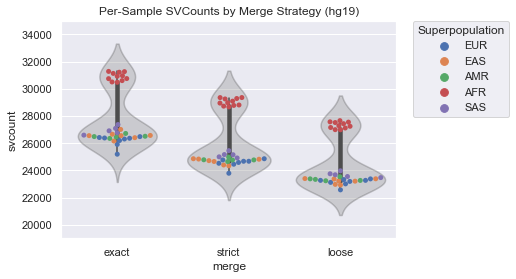

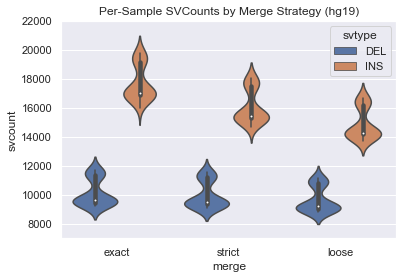

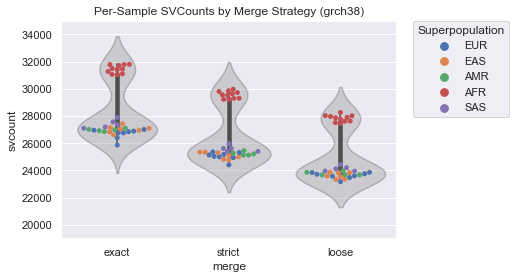

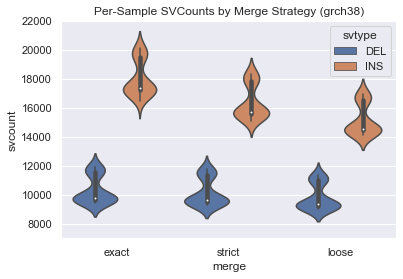

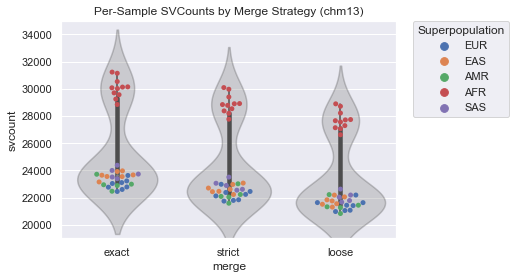

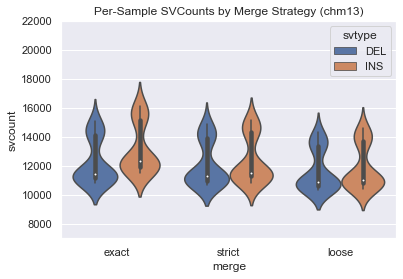

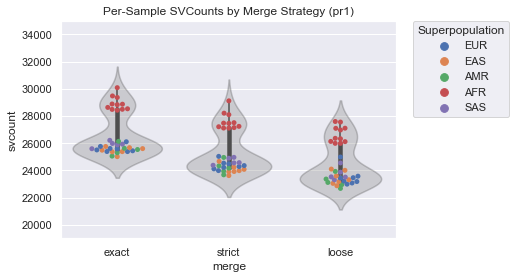

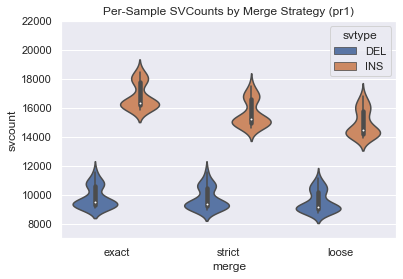

In [20]:
merge_strategy_plots(sv_counts, sv_counts_byty, "hg19")
merge_strategy_plots(sv_counts, sv_counts_byty, "grch38")
merge_strategy_plots(sv_counts, sv_counts_byty, "chm13")
merge_strategy_plots(sv_counts, sv_counts_byty, "pr1")


# Het/Hom Ratios per-sample

In [13]:
view = []
for name, big_df in [("exact", exact_gt_counts), ("strict", strict_gt_counts), ("loose", loose_gt_counts)]:
    for i, d in big_df.groupby(["reference", "sample", "Superpopulation"]):
        d.set_index("svtype", inplace=True)
        view.append([*i, name, d.loc["DEL"].Ratio, d.loc["INS"].Ratio, d.loc["TOT"].Ratio])
view = pd.DataFrame(view, columns=["reference", 
                                   "sample", 
                                   "Superpopulation", 
                                   "merge", 
                                   "DEL Ratio", 
                                   "INS Ratio", 
                                   "Ratio"])

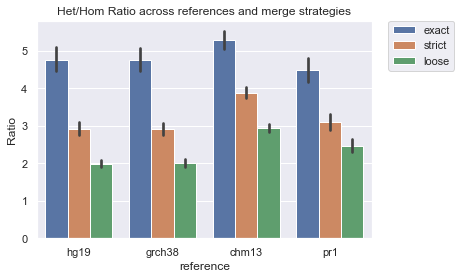

In [14]:
p = sb.barplot(data=view, x="reference", hue="merge", y="Ratio", order=ref_order)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
hide = p.set(title="Het/Hom Ratio across references and merge strategies")

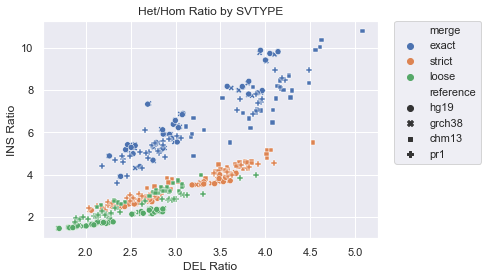

In [16]:
p = sb.scatterplot(data=view, 
                   x="DEL Ratio", 
                   y="INS Ratio", 
                   hue="merge", 
                   style="reference", 
                   markers=True,
                  style_order=ref_order)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
hide = p.set(title="Het/Hom Ratio by SVTYPE")

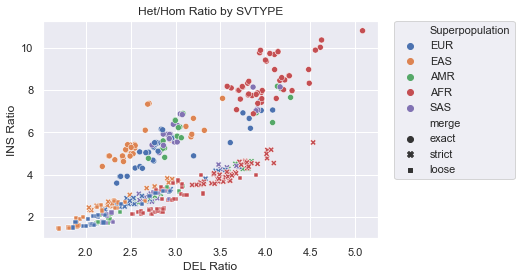

In [18]:
p = sb.scatterplot(data=view, 
                   x="DEL Ratio", 
                   y="INS Ratio", 
                   hue="Superpopulation", 
                   style="merge", 
                   markers=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
hide = p.set(title="Het/Hom Ratio by SVTYPE")

In [19]:
view.groupby(["reference", "merge"]).mean().applymap("{0:.2f}".format).T

reference chm13              grch38               hg19                pr1  \
merge     exact loose strict  exact loose strict exact loose strict exact   
DEL Ratio  3.93  2.77   3.54   3.10  2.26   2.79  3.10  2.26   2.80  3.07   
INS Ratio  7.48  3.16   4.28   6.51  1.85   3.01  6.54  1.85   3.00  5.90   
Ratio      5.29  2.95   3.89   4.75  2.00   2.92  4.76  2.00   2.92  4.49   

reference               
merge     loose strict  
DEL Ratio  2.50   2.86  
INS Ratio  2.45   3.26  
Ratio      2.47   3.10

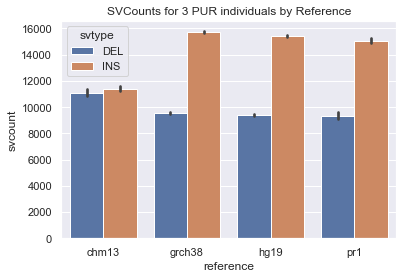

In [59]:
use_type = 1
a = strict_sv_counts[use_type].copy()
a["Population"] = metadata.loc[strict_sv_counts[use_type]["sample"]]["Population code"].reset_index(drop=True)
p = sb.barplot(data=a[a["Population"] == "PUR"], x="reference", y="svcount", hue="svtype")
hide = p.set(title="SVCounts for 3 PUR individuals by Reference")